## Importing Libraries

In [1]:
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

## Device

In [2]:
# Device setup
device = (
    "cuda:0" if torch.cuda.is_available() else # Nvidia GPU
    "mps" if torch.backends.mps.is_available() else # Apple Silicon GPU
    "cpu"
)
print(f"Device = {device}")

Device = mps


## Dataset

In [3]:
# Dataset path
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
# Dataset download
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
# Custom Dataset
class MNIST_Dataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx].reshape(1, 28, 28)
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
# Full Dataset
test_ds = MNIST_Dataset(x_valid, y_valid, transform=transfrom)
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

In [7]:
# 0 and 1 Dataset
x_train_01 = x_train[y_train <= 1]
y_train_01 = y_train[y_train <= 1]
x_valid_01 = x_valid[y_valid <= 1]
y_valid_01 = y_valid[y_valid <= 1]

test_ds_01 = MNIST_Dataset(x_valid_01, y_valid_01, transform=transfrom)
test_dl_01 = DataLoader(test_ds_01, batch_size=1000, shuffle=False)

## Model

In [8]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [9]:
# Load model
base_model = MNIST_CNN().to(device)
base_model.load_state_dict(torch.load("mnist_cnn.pth"))
model_01 = MNIST_CNN().to(device)
model_01.load_state_dict(torch.load("mnist_cnn_01.pth"))

<All keys matched successfully>

## Evaluation

In [10]:
correct = [0] * 10
total = [0] * 10

In [11]:
# Accuracy on each label
def evaluate_labels(model, test_dl):
    model.eval()
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            _, predicted = torch.max(output, 1)
            for i in range(len(yb)):
                label = yb[i]
                total[label] += 1
                if predicted[i] == label:
                    correct[label] += 1
    return [correct[i] / total[i] for i in range(10)]

Label 0, Accuracy: 0.9556
Label 1, Accuracy: 0.9859
Label 2, Accuracy: 0.9182
Label 3, Accuracy: 0.9670
Label 4, Accuracy: 0.9776
Label 5, Accuracy: 0.9049
Label 6, Accuracy: 0.9690
Label 7, Accuracy: 0.8862
Label 8, Accuracy: 0.9633
Label 9, Accuracy: 0.8158


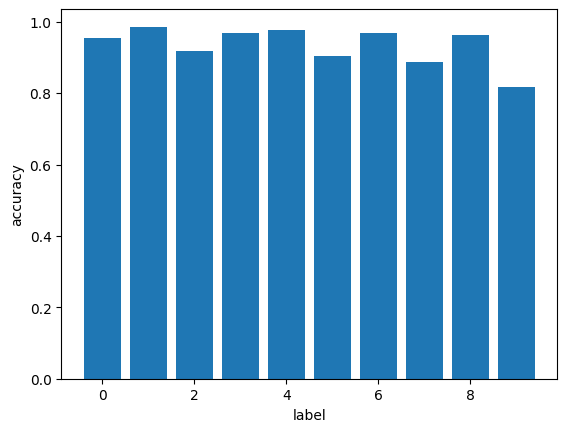

In [12]:
for i, acc in enumerate(evaluate_labels(base_model, test_dl)):
    print(f"Label {i}, Accuracy: {acc:.4f}")
    
plt.bar(range(10), evaluate_labels(base_model, test_dl))
plt.xlabel("label")
plt.ylabel("accuracy")
plt.show()

## Arithmetic Operations

In [13]:
# Subtract model weights
def subtract(model1, model2):
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        p1.data -= p2.data

subtract(base_model, model_01)        

## Re-Evaluation

Label 0, Accuracy: 0.8066
Label 1, Accuracy: 0.9627
Label 2, Accuracy: 0.9266
Label 3, Accuracy: 0.9498
Label 4, Accuracy: 0.9298
Label 5, Accuracy: 0.8226
Label 6, Accuracy: 0.9710
Label 7, Accuracy: 0.7523
Label 8, Accuracy: 0.9627
Label 9, Accuracy: 0.8665


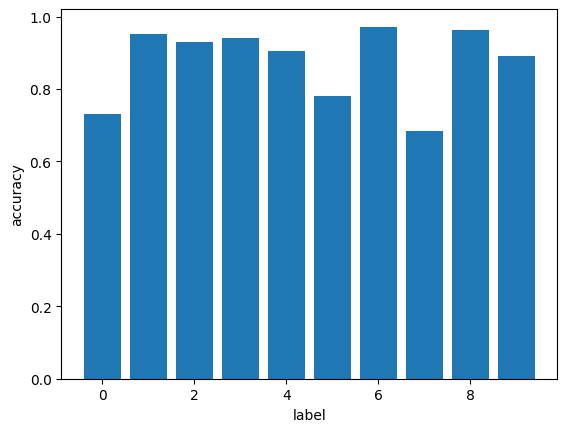

In [14]:
## Re-Evaluation&Inference
for i, acc in enumerate(evaluate_labels(base_model, test_dl)):
    print(f"Label {i}, Accuracy: {acc:.4f}")

plt.bar(range(10), evaluate_labels(base_model, test_dl))
plt.xlabel("label")
plt.ylabel("accuracy")
plt.show()